# Machine Learning for Pneumonia Detection 

## Intro

Every year approximately 4 million people die of pneumonia, and about 450 million people are affected by this disease. Pneumonia is the leading cause of death in developing countries and the very old, the very young and the chronically ill. Pneumonia is an inflammatory condition that impacts the alveoli of the lungs, the small structures where blood is oxygenated. This causes the symptoms of coughing, chest pain, and, difficultly breathing. 

Pneumonia is often caused by infection by either viruses or bacteria, but determining the exact pathogen responsible is difficult.  Diagnosis is usually based on symptoms, with chest x-rays being used to confirm the diagnosis. Pneumonia is treated with antivirals or antibiotics depending on the cause, with supplemental oxygen therapy used if blood oxygen levels drop. 

In this project, we will investigate the problem of confirming a pneumonia diagnosis using a chest x-ray and machine learning. I will use a public dataset of chest x-rays from Zhang et al, 2018. I will use two methods of training, in one method I will create a new classifier to label the images, and in another method I will use transfer learning from the publicly available image classifier VGG19 and the image net weights. 

## Import Data and Libraries

First we will download the dataset, extract the images and create the testing and training sets. 

In [1]:
import os
import zipfile
import glob
from pathlib import Path
import warnings 
warnings.filterwarnings("ignore")
%pprint ON
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

Pretty printing has been turned OFF


In [2]:
# Check for the zipped data, download it if it doesn't exist 
if not os.path.isfile('chest-xray-pneumonia.zip'):
    print("Data has not been downloaded, acquiring the data for this notebook...")
    os.system("""
    curl -L -o chest-xray-pneumonia.zip https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia
    """)
    print("Data downloaded")

# Unzip the data
if not os.path.exists('chest_xray'):
    with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
        print("Extracting ...")
        zip_ref.extractall()
        print('Done')

data_dir = Path('chest_xray/chest_xray')
train_dir = data_dir/'train'
val_dir = data_dir/'val'
test_dir = data_dir/'test'

Data has not been downloaded, acquiring the data for this notebook...


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2349M  100 2349M    0     0  11.3M      0  0:03:26  0:03:26 --:--:-- 11.3M


Data downloaded
Extracting ...
Done


In [3]:
# Create dataframes of training and test data for ease of data analysis and visualization

def df_from_path(foldr):
    filepath = []
    label = []

    folders = os.listdir(foldr)

    for folder in folders:
        if folder.startswith("."):
            continue
        f_path = os.path.join(foldr, folder)
        imgs = os.listdir(f_path)

        for img in imgs:
            img_path = os.path.join(f_path, img)
            filepath.append(img_path)
            label.append(folder)
            
    file_path_series = pd.Series(filepath, name = 'filepath')
    label_path_series = pd.Series(label, name = 'label')
    df_out = pd.concat([file_path_series, label_path_series], axis = 1)
    return df_out

df_train = df_from_path(train_dir)
df_test = df_from_path(test_dir)

print(f"The shape of the training set data is: {df_train.shape}")
print(f"The shape of the test set data is:     {df_test.shape}")

The shape of the training set data is: (5218, 2)
The shape of the test set data is:     (624, 2)


### Tools and Libraries 

I will use pandas, seaborn, keras, and sci-kit learns to create the classification pipeline. Pandas is used to create dataframes of the training, validation, and testing images and labels. Seaborn is used for creating graphs and previewing the images. Keras is the main library used for the machine learning pipeline for model creation and evaluation. Sci-kit learns is used for assessing model metrics.

In [4]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
# from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

2026-02-17 19:37:10.101346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Set Qualities
This dataset is 5863 jpeg image files split between the pneumonia and normal categories. The images are 224x224 pixels, in greyscale. They were obtained from a retrospective cohorts of pediatric patients from Guangzhou Women and Childerns Medical Center. We will use 4695 images for training, 521 images for training validation, and 624 images for testing our models. Some issues we need to be aware of with this dataset are the greyscale values, and uneven distribution of categories. To work around these issues we will perform image normalization to convert the greyscale values from 0-255 to 0.0-1.0. We will also perform data augmentation by random zoom, random rotation, horizontal flips, and random x and y translation. This will allow us to provide more images for training, which should increase the accuracy of the trained model. 

In [5]:
labels = ['NORMAL', 'PNEUMONIA']
image_size = (224, 224)
batch_size = 32

# Load datasets using Keras builtin module
print('Training Images:')
train = image_dataset_from_directory(
    directory = train_dir,
    labels = 'inferred',
    validation_split = 0.1,
    subset = 'training',
    # label_mode = 'binary',
    class_names = labels,
    image_size = image_size,
    batch_size = batch_size,
    color_mode = 'grayscale',
    seed = 356,
)
print(' ')
print('Validation Images:')
val = image_dataset_from_directory(
    directory = train_dir,
    labels = 'inferred',
    validation_split = 0.1,
    subset = 'validation',
    # label_mode = 'binary',
    class_names = labels,
    image_size = image_size,
    batch_size = batch_size,
    color_mode = 'grayscale',
    seed = 356,
)
print(' ')
print('Testing Images:')
test = image_dataset_from_directory(
    directory = test_dir,
    labels = 'inferred',
    # label_mode='binary',
    class_names = labels,
    image_size = image_size,
    batch_size = batch_size,
    color_mode = 'grayscale',
    seed = 356,
)

Training Images:
Found 5216 files belonging to 2 classes.
Using 4695 files for training.


I0000 00:00:1771357031.627227 2650913 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6017 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


 
Validation Images:
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
 
Testing Images:
Found 624 files belonging to 2 classes.


In [6]:
# Extract and encode class labels 
train_labels = train.class_names
test_labels = test.class_names
val_labels = val.class_names

label_encoder = LabelEncoder()
label_encoder.fit(labels)
train_labels_encoded = label_encoder.transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
val_labels_encoded = label_encoder.transform(val_labels)

In [7]:
for img_batch, labels_batch in train:
    print(f"Shape of X_train : {img_batch.shape}")
    print(f"Shape of Y_train : {labels_batch.shape}")
    break

Shape of X_train : (32, 224, 224, 1)
Shape of Y_train : (32,)


In [8]:
# Normalize pixel values of the data

train = train.map(lambda x, y: (x / 255.0, y))
test = test.map(lambda x, y: (x / 255.0, y))
val = val.map(lambda x, y: (x / 255.0, y))

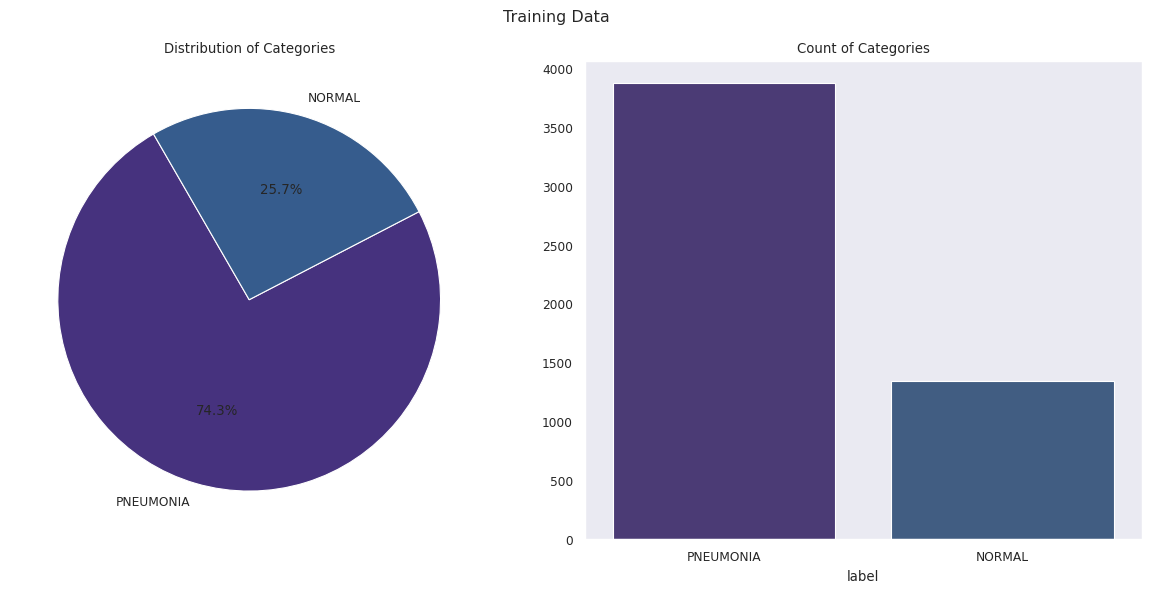

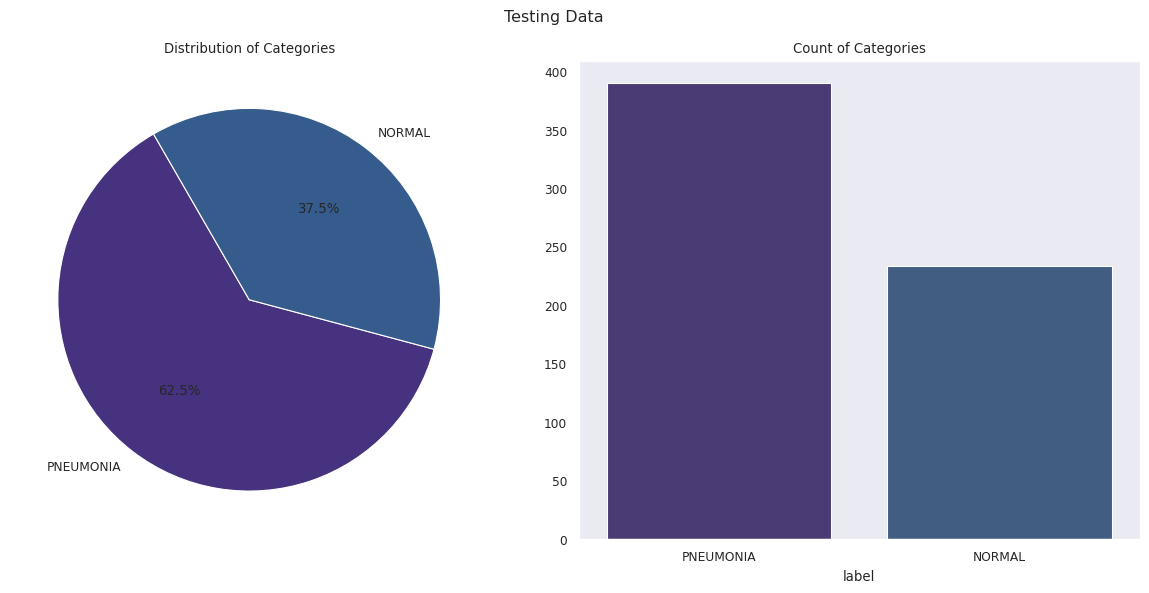

In [9]:
# Graph the data to see if there are any issues with class sizes 
sns.set_style('dark')
sns.set_context('paper')    
palette = sns.color_palette('viridis')
sns.set_palette(palette)

def plot_dist_count(df_in, dataset_name):
    count = df_in['label'].value_counts()
    
    fig, axs = plt.subplots(1, 2, figsize = (12, 6), facecolor = 'white')

    fig.suptitle(f'{dataset_name} Data')

    axs[0].pie(count, labels = count.index, autopct = '%1.1f%%', startangle = 120)
    axs[0].set_title('Distribution of Categories')
    
    sns.barplot(x = count.index, y = count.values, ax = axs[1], palette = palette)
    axs[1].set_title('Count of Categories')
    
    plt.tight_layout() 
    plt.show()

plot_dist_count(df_train, 'Training')
plot_dist_count(df_test, 'Testing')

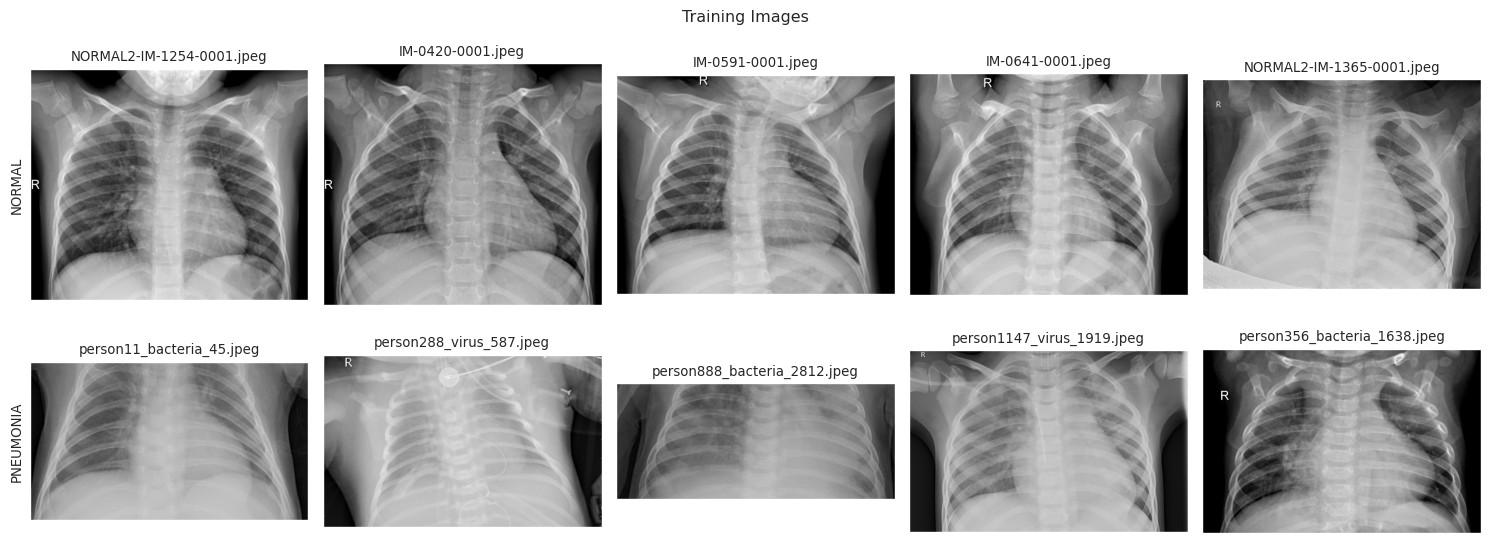

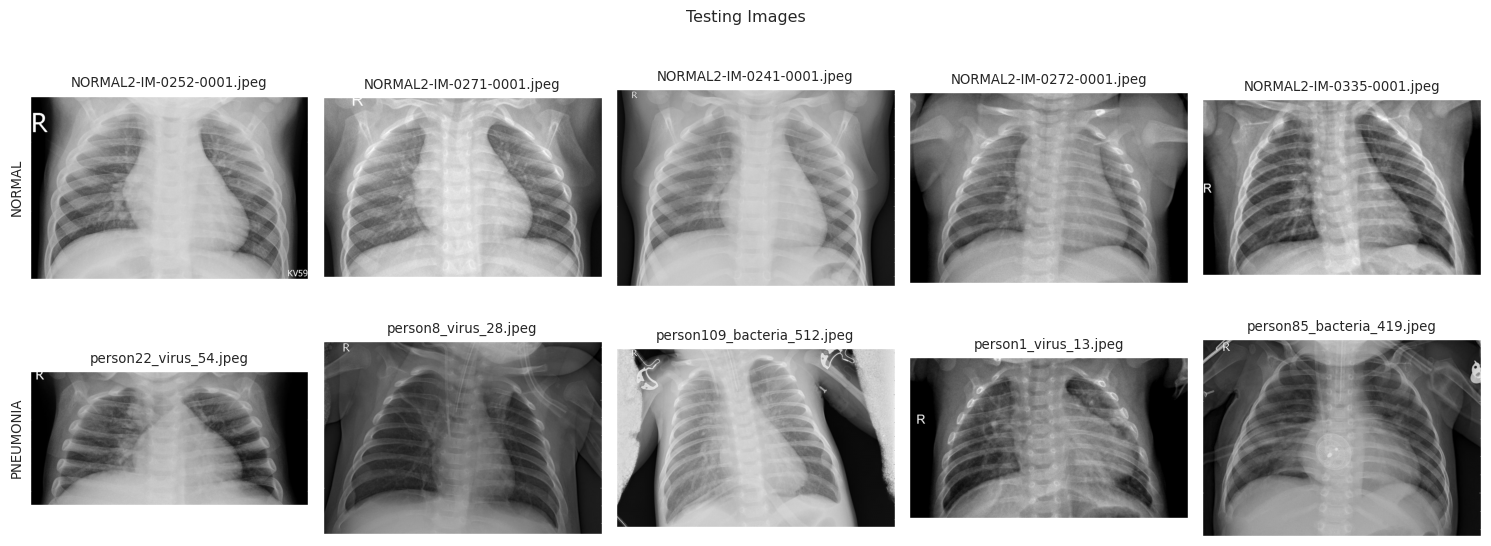

In [10]:
# Show some example images for each class in the training and testing datasets

def show_images(path, labels, num_images = 5):
    data_set_name = os.path.split(path)[1]

    fig, axs = plt.subplots(2, num_images, figsize = (15, 6), facecolor = 'white')
    fig.suptitle(f'{data_set_name.title()}ing Images')
    
    for j, label in enumerate(labels):
        new_path = path/label
        img_filenames = os.listdir(new_path)
        num_images = min(num_images, len(img_filenames))
    
        for i, img_filename in enumerate(img_filenames[:num_images]):
            img_path = os.path.join(new_path, img_filename)
            # print(img_path)
            img = mpimg.imread(img_path)
            # print(img)
    
            axs[j][i].imshow(img, cmap='gray')
            axs[j][i].axis('image')
            axs[j][i].set_xticks([])
            axs[j][i].set_yticks([])
            axs[j][i].set_title(img_filename)
            # axs[j][i].set_ylabel(label)
        
        axs[j][0].set_ylabel(label)
    fig.align_labels()
    plt.tight_layout()
    plt.show()

show_images(train_dir, labels)
show_images(test_dir, labels)

In [11]:
# Define the data augmentation that will be used to make the dataset larger 

data_augmentation_layers = [
    RandomFlip('horizontal'),
    RandomRotation(0.3),
    RandomZoom(
        height_factor = 0.2,
        width_factor = 0.2
    ),
    RandomTranslation(
        height_factor = 0.1,
        width_factor = 0.1,
    )
]


def data_augmentation(m):
    for layer in data_augmentation_layers:
        m.add(layer)

### Model Creation

In [12]:
input_shape = (224, 224, 1)

model = Sequential()
model.add(keras.Input(shape = input_shape))
data_augmentation(model)
model.add(Conv2D(32, (3, 3), strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3, 3), strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3, 3), strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
model.add(Conv2D(128, (3, 3), strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
model.add(Conv2D(256, (3, 3), strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy', 'recall', 'precision'])
model.summary(show_trainable = True)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ random_flip (RandomFlip)    │ (None, 224, 224, 1)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ random_rotation             │ (None, 224, 224, 1)   │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ random_zoom (RandomZoom)    │ (None, 224, 224, 1)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ random_translation          │ (None, 224, 224, 1)   │          0 │   -   │
│ (RandomTranslation)         │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d (Conv2D)             │ (None, 224, 224, 32)  │        320 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization         │ (None, 224, 224, 32)  │        128 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d               │ (None, 112, 112, 32)  │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_1 (Conv2D)           │ (None, 112, 112, 64)  │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_1       │ (None, 112, 112, 64)  │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_1             │ (None, 56, 56, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_2 (Conv2D)           │ (None, 56, 56, 64)    │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_2       │ (None, 56, 56, 64)    │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_2             │ (None, 28, 28, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_3 (Conv2D)           │ (None, 28, 28, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 28, 28, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_3       │ (None, 28, 28, 128)   │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_3             │ (None, 14, 14, 128)   │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_4 (Conv2D)           │ (None, 14, 14, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 14, 14, 256)   │          0 │   - 

 Total params: 6,849,729 (26.13 MB)

 Trainable params: 6,848,641 (26.13 MB)

 Non-trainable params: 1,088 (4.25 KB)

### Train Model

We use learning rate reduction to prevent over fitting the data set, we also set up also set up early stopping to prevent over fitting. Reducing the learning rate when the validation accuracy platues helps prevent overfitting by reducing the change in the model weights when the validation accuracy is stagnant. Early stopping prevents overfitting by minimizing validation loss, which is an indicator how well the model correctly predicted the validation data.

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 4, verbose = 1, factor = 0.3, min_lr = 0.0001)

early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 9, verbose = 1, restore_best_weights = True, start_from_epoch = 5)

In [14]:
history = model.fit(x = train, epochs = 50, validation_data = val, callbacks =  [learning_rate_reduction, early_stopping])
# history = model.fit(x = train, epochs = 50, validation_data = val, callbacks =  [learning_rate_reduction])

Epoch 1/50


E0000 00:00:1771357038.305689 2650913 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2026-02-17 19:37:19.194946: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.7906 - loss: 0.8838 - precision: 0.8565 - recall: 0.8626 - val_accuracy: 0.7447 - val_loss: 126.9981 - val_precision: 0.7447 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.8330 - loss: 0.4288 - precision: 0.9074 - recall: 0.8632 - val_accuracy: 0.7447 - val_loss: 198.0883 - val_precision: 0.7447 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.8694 - loss: 0.3377 - precision: 0.9323 - recall: 0.8887 - val_accuracy: 0.7447 - val_loss: 111.2322 - val_precision: 0.7447 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.8833 - loss: 0.3378 - precision: 0.9296 - recall: 0.9120 - val_accuracy: 0.9136 - val_loss: 0.2802 - val_precision: 0.9173 - val_recall: 0.9716 - learning_rate: 0.0010
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accur

### Transfer Learning

In transfer learning a previously trained model is applied to a different but related task. This allows one to use a pre-trained model as a starting point and allows features learned during training on one task to be applied to a new task. This allows for better performance with less data and training, as your model is not starting from zero. Transfer learning involves fine-tuning the pre-trained model by changing the final layers for the new task, allowing the base layers to be reused. This allows knowledge gained during previous, such as image recognition, to quickly and efficiently be generalized to a new task.

In [15]:
base_model = keras.applications.VGG19(weights = 'imagenet', include_top = False)
base_model.trainable = False

t_model = Sequential()
t_model.add(keras.Input(shape = (224, 224, 1)))
data_augmentation(t_model)
t_model.add(Conv2D(3, (3, 3), strides = 1, padding = 'same', activation = 'relu'))
# t_model.add(keras.layers.Reshape((-1, 3)))
t_model.add(base_model)
t_model.add(BatchNormalization())
t_model.add(Flatten())
t_model.add(Dropout(0.45))
t_model.add(Dense(800, activation = 'relu'))
t_model.add(Dropout(0.25))
t_model.add(Dense(130, activation = 'relu'))
t_model.add(Dense(1, activation = 'sigmoid'))
t_model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy', 'recall', 'precision'])
t_model.summary(show_trainable = True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ random_flip (RandomFlip)    │ (None, 224, 224, 1)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ random_rotation             │ (None, 224, 224, 1)   │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ random_zoom (RandomZoom)    │ (None, 224, 224, 1)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ random_translation          │ (None, 224, 224, 1)   │          0 │   -   │
│ (RandomTranslation)         │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_5 (Conv2D)           │ (None, 224, 224, 3)   │         30 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ vgg19 (Functional)          │ (None, 7, 7, 512)     │ 20,024,384 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_5       │ (None, 7, 7, 512)     │      2,048 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 25088)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_4 (Dropout)         │ (None, 25088)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 800)           │ 20,071,200 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_5 (Dropout)         │ (None, 800)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 130)           │    104,130 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 1)             │        131 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 40,201,923 (153.36 MB)

 Trainable params: 20,176,515 (76.97 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

In [16]:
t_history = t_model.fit(x = train, epochs = 50, validation_data = val, callbacks =  [learning_rate_reduction, early_stopping])
# t_history = t_model.fit(x = train, epochs = 50, validation_data = val, callbacks =  [learning_rate_reduction])

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 200ms/step - accuracy: 0.8469 - loss: 0.4361 - precision: 0.8927 - recall: 0.9022 - val_accuracy: 0.8407 - val_loss: 0.4588 - val_precision: 0.9967 - val_recall: 0.7887 - learning_rate: 0.0010
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 180ms/step - accuracy: 0.8788 - loss: 0.2875 - precision: 0.9188 - recall: 0.9180 - val_accuracy: 0.8964 - val_loss: 0.2449 - val_precision: 0.9827 - val_recall: 0.8763 - learning_rate: 0.0010
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 180ms/step - accuracy: 0.8946 - loss: 0.2506 - precision: 0.9274 - recall: 0.9309 - val_accuracy: 0.8388 - val_loss: 0.3644 - val_precision: 1.0000 - val_recall: 0.7835 - learning_rate: 0.0010
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8978 - loss: 0.2405 - precision: 0.9340 - recall: 0.9277
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 0.8995 - loss: 0.2315 - precisio

In [17]:
print("Small CNN results: ")
test_results = model.evaluate(test)
print(f"\nLoss of the model is      {test_results[0]:.4f}")
print(f"Accuracy of the model is  {test_results[1]*100:.2f}%")
print("\n\n\n")
print("Transfer Learning VGG19 model results: ")
t_test_results = t_model.evaluate(test)
print(f"\nLoss of the model is      {t_test_results[0]:.4f}")
print(f"Accuracy of the model is  {t_test_results[1]*100:.2f}%")

Small CNN results: 
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8830 - loss: 0.4038 - precision: 0.8484 - recall: 0.9897

Loss of the model is      0.4038
Accuracy of the model is  88.30%




Transfer Learning VGG19 model results: 
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.8894 - loss: 0.2638 - precision: 0.9105 - recall: 0.9128

Loss of the model is      0.2638
Accuracy of the model is  88.94%


### Post Training Analysis
- Classification Report and meaning
- Confusion matrix and meaning


Sensitivity (Recall for TB): How many TB cases your model correctly finds.

Specificity: How many healthy cases your model correctly identifies.

Positive Predictive Value (PPV): When your model says “TB”, how often it’s right.

Negative Predictive Value (NPV): When your model says “Healthy”, how often it’s right.

👉 Tip: You don’t need to get the “best” numbers. Focus on explaining what the metrics mean and what you learned.



Small CNN


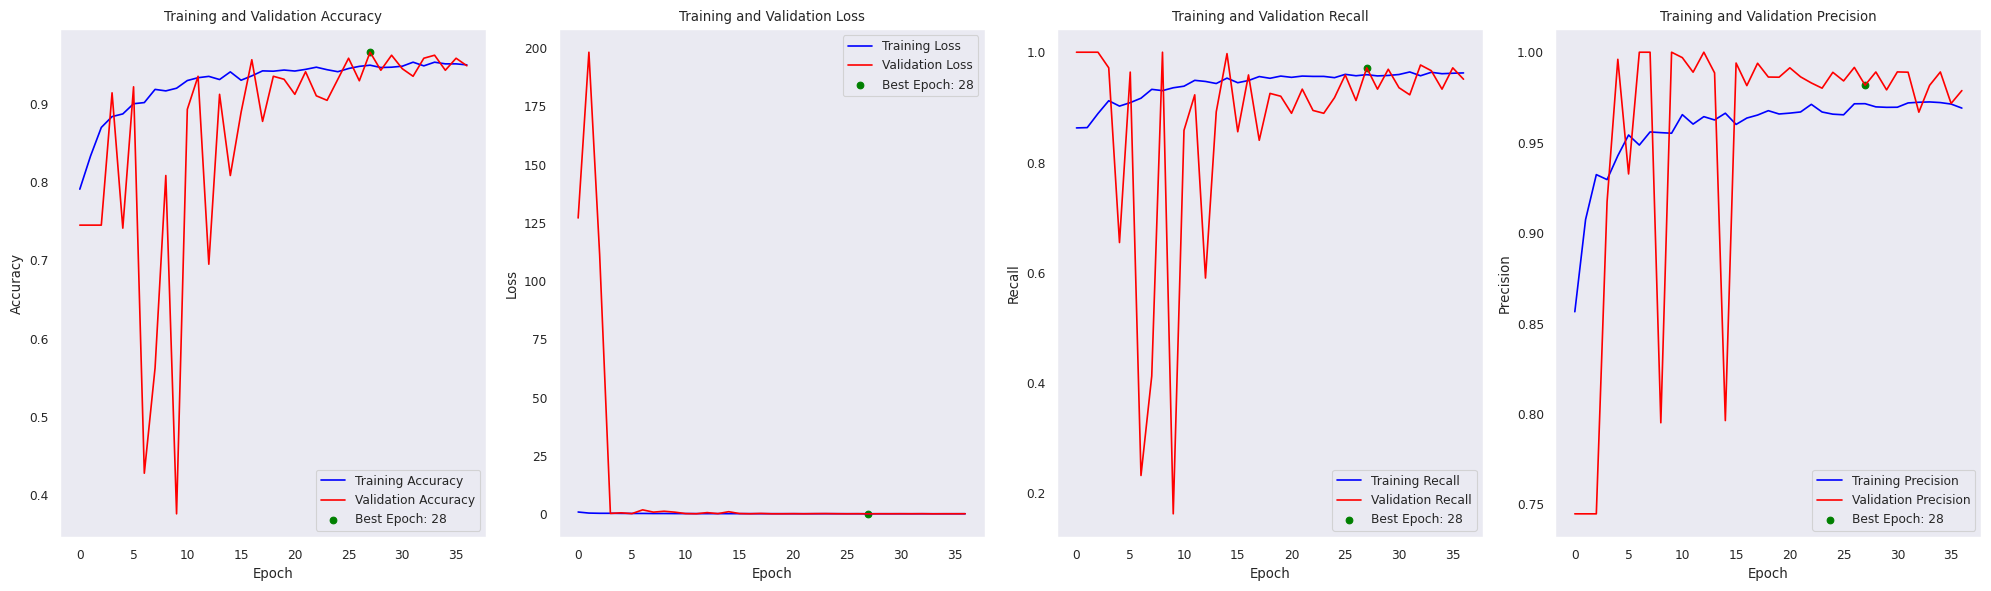

Transfer Learning


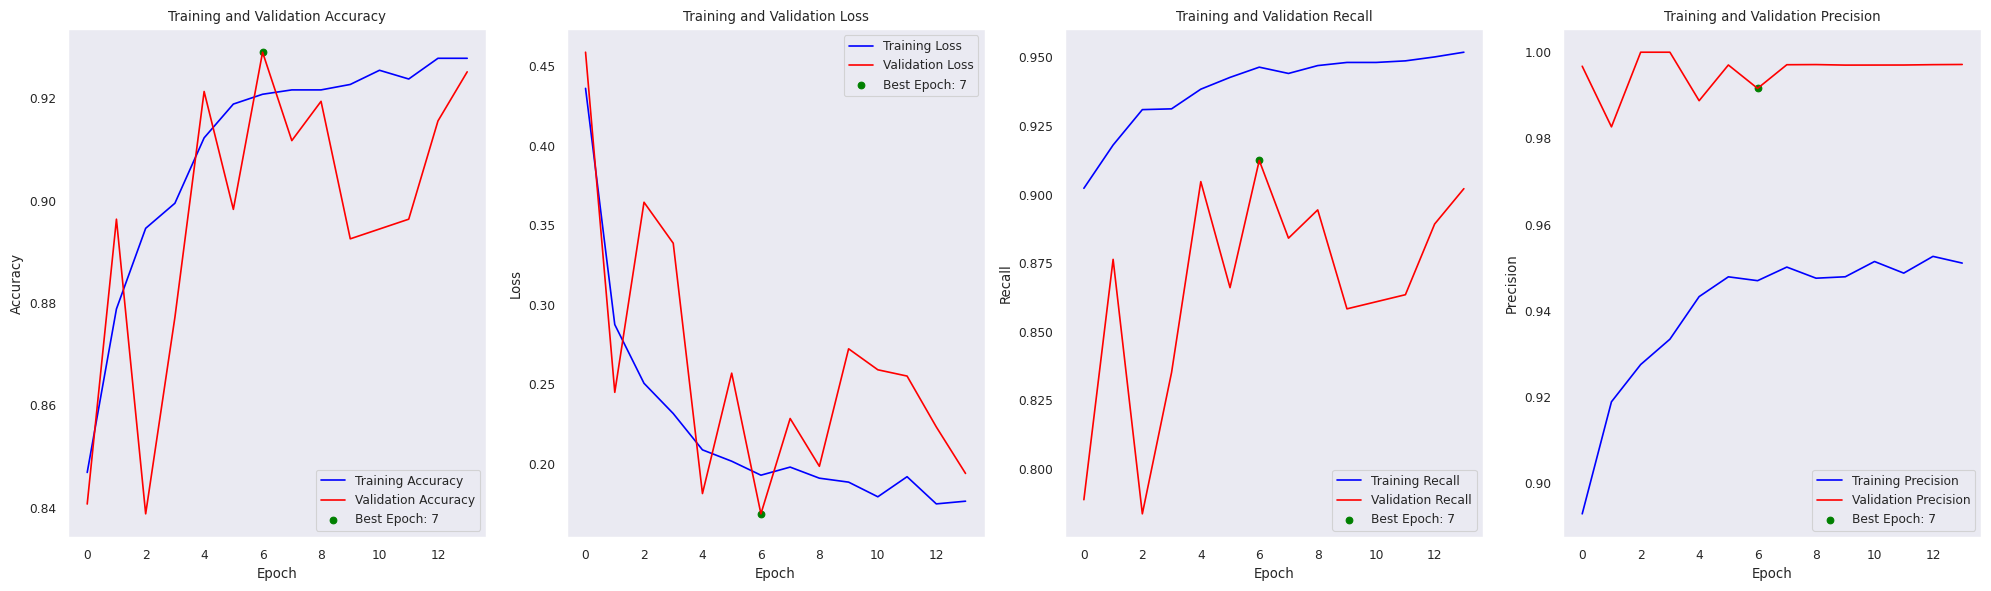

In [18]:
def best_epoch(training_history):
    return training_history.history['val_accuracy'].index(max(training_history.history['val_accuracy'])) + 1

def plot_training_data(train_hist):
    
    # plt.style.use('seaborn-darkgrid')
    metrics = ['accuracy', 'loss', 'recall', 'precision']
    fig, axs = plt.subplots(1, len(metrics), figsize = (20, 6))
    best_e = best_epoch(train_hist)

    for i, metric in enumerate(metrics):
        axs[i].plot(train_hist.history[metric], label = f"Training {metric.title()}", color = 'blue')
        axs[i].plot(train_hist.history[f"val_{metric}"], label = f"Validation {metric.title()}", color = 'red')
        axs[i].scatter(best_e - 1, train_hist.history[f"val_{metric}"][best_e - 1], color = 'green', label = f"Best Epoch: {best_e}")
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(f"{metric.title()}")
        axs[i].set_title(f"Training and Validation {metric.title()}")
        axs[i].legend()

    plt.tight_layout()
    plt.show()

print("Small CNN")
plot_training_data(history)
print("Transfer Learning")
plot_training_data(t_history)

#### Confusion Matrix

Confusion Matrix for Small CNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


2026-02-17 19:50:50.032454: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


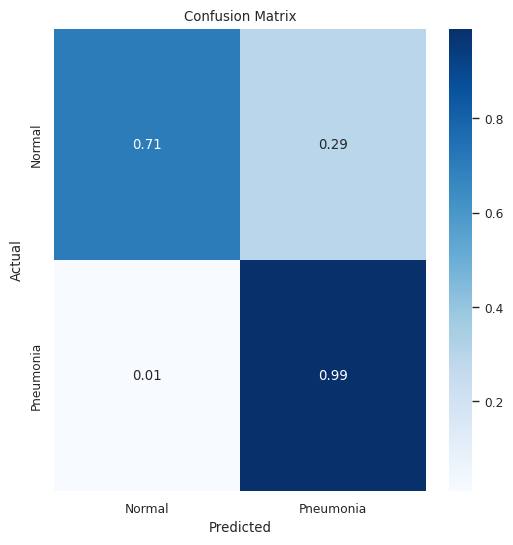

              precision    recall  f1-score   support

     Healthy       0.98      0.71      0.82       234
   Pneumonia       0.85      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.85      0.87       624
weighted avg       0.90      0.88      0.88       624



In [19]:
def conf_mat(model):
    y_true = []
    y_pred = []

    for x,y in test:
        y = tf.concat(y, axis = 1) 
    # print(y.numpy())
        y_true.append(y)
        y_pred.append((model.predict(x) > 0.5).astype('int32'))

# print(y_true)
# print(y_pred)
    y_pred = tf.concat(y_pred, axis = 0)
    y_true = tf.concat(y_true, axis = 0)

    cm = confusion_matrix(y_true, y_pred, normalize = 'true')
    
    plt.figure(figsize=(6,6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia']) 
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title(f"Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    print(classification_report(y_true, y_pred, target_names = ['Healthy', 'Pneumonia']))

print('Confusion Matrix for Small CNN')
conf_mat(model)

From the confusion matrix for the small CNN, we can see the false positive and false negative rates. Our false positive situation, where a healthy individual's x-ray is predicted to have pneumonia occurs 26% of the time. Although the false positive rate seems high, the main focus of a diagnostic test is to minimize false negative results, as those are the cases where there is the most potential harm. 

Confusion Matrix for Transfer Learning CNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


2026-02-17 19:50:53.140228: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


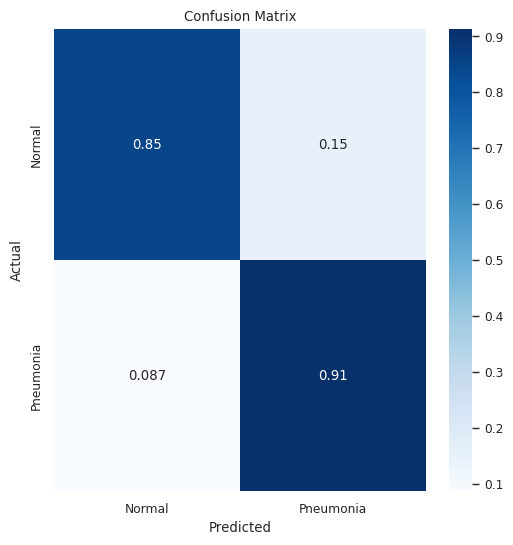

              precision    recall  f1-score   support

     Healthy       0.85      0.85      0.85       234
   Pneumonia       0.91      0.91      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624



In [20]:
print('Confusion Matrix for Transfer Learning CNN')
conf_mat(t_model)

In the transfer learning CNN we achieved more balanced results between the false negative rate (11%) and the false positive rate (12%). Although these more balanced results show the models learning both classes equally, this is not ideal for the use case of a medical diagnostic tool. 